In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse
import random
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfTransformer

TEST_SET_THRESHOLD = 10
TEST_SET_HOLDOUT = 0.2
BEST_ALFA = 0.92

In [2]:
tracks = pd.read_csv('../input/tracks.csv')
train = pd.read_csv('../input/train.csv')
target = pd.read_csv('../input/target_playlists.csv')

# Defining methods to create csr matrices

In [3]:
def classify_durations(data):
    data.loc[tracks['duration_sec'].isin(range(60)),'duration_sec'] = 1
    data.loc[tracks['duration_sec'].isin(range(60,120)), 'duration_sec'] = 2
    data.loc[tracks['duration_sec'].isin(range(120,180)), 'duration_sec'] = 3
    data.loc[tracks['duration_sec'].isin(range(180,240)), 'duration_sec'] = 4
    data.loc[tracks['duration_sec'].isin(range(240,300)), 'duration_sec'] = 5
    data.loc[tracks['duration_sec'].isin(range(300,200000)), 'duration_sec'] = 6

def build_urm_csr(data):
    fill_data = np.ones(data.shape[0])
    #posso usare gli id direttamente solo perchè come già detto sono consistenti
    row = data['playlist_id'].values
    col = data['track_id'].values
    n_pl = np.amax(data['playlist_id']) + 1
    n_tr = np.amax(data['track_id']) + 1
    
    return sparse.csr_matrix((fill_data, (row, col)), dtype=float, shape=(n_pl, n_tr))

def build_icm_csr(data):
    
    classify_durations(data)
    
    albums_id = data['album_id']
    artists_id = data['artist_id']
    durations = data['duration_sec']
    tracks = data['track_id']
    
    albums_max = np.amax(albums_id)
    artists_max = np.amax(artists_id)
    durations_max = np.amax(durations)
    number_of_songs = data.shape[0]
    
    icm_csr_matrix = sparse.csr_matrix((number_of_songs, albums_max + artists_max + durations_max + 3), dtype=np.uint32)
    
    icm_csr_matrix[tracks,albums_id] = 1
    icm_csr_matrix[tracks, albums_max + artists_id] = 1
    icm_csr_matrix[tracks, albums_max + artists_max + durations] = 1

    return icm_csr_matrix

# SPLITTING DATASET

In [4]:
#Raggruppiamo per playlist_id, le celle conterranno il count() del gruppo, quindi il numero di canzoni per playlist
grouped = train.groupby('playlist_id')['track_id'].nunique()

#Prendiamo le playlist che superano il numero di elementi del TEST_SET_THRESHOLD
clipped = grouped.index[grouped>TEST_SET_THRESHOLD].tolist()

#Adesso prendiamo a caso degli indici di playlist in percentuale di TEST_SET_HOLDOUT
#ATTENZIONE, la percentuale viene calcolata sulla lunghezza di clipped, che avrà un numero di elementi inferiore a train
#Questo significa che il 20% di clipped sarà circa il 14% del train, la percentuale è da aggiustare tenendo conto di sto fatto
test_set_indices = [ clipped[i] for i in sorted(random.sample(range(len(clipped)), int(TEST_SET_HOLDOUT*len(clipped)))) ]

#Andiamo a estrarre dal train TUTTE le canzoni delle playlist estratte a sorte nella riga prima
test_groups = train.loc[train['playlist_id'].isin(test_set_indices)]

#Andiamo a creare un dataframe vuoto, a cui appenderemo tutte le canzoni da ficcare nel test_set con una .append()
test_set = pd.DataFrame(columns=["playlist_id","track_id"])

#Per ogni gruppo prendiamo le ultime 10 canzoni e le appendiamo al test_set
for name, group in test_groups.groupby('playlist_id'):
    test_set = test_set.append(group.tail(10))
    
#Togliamo le canzoni del test set al train, salvandolo in una nuova variabile 
#Questo è solo un trick per fare la differenza insiemistica
training_set = pd.concat([train, test_set, test_set]).drop_duplicates(keep=False)

#Ora passiamo training_set e test_set a csr_matrix
urm_csr = build_urm_csr(training_set)
test_set_csr = build_urm_csr(test_set)
icm_csr = build_icm_csr(tracks)

test_set_playlists = test_set['playlist_id'].unique()

C:\Users\giuse\Anaconda3\envs\tensorflow\lib\site-packages\scipy\sparse\compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


# EVALUATION METHODS

In [13]:
def precision(recommended_items, relevant_items):
    
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    precision_score = np.sum(is_relevant, dtype=np.float32) / len(is_relevant)
    
    return precision_score

def recall(recommended_items, relevant_items):
    
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    recall_score = np.sum(is_relevant, dtype=np.float32) / relevant_items.shape[0]
    
    return recall_score

def MAP(recommended_items, relevant_items):
       
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    # Cumulative sum: precision at 1, at 2, at 3 ...
    p_at_k = is_relevant * np.cumsum(is_relevant, dtype=np.float32) / (1 + np.arange(is_relevant.shape[0]))
    
    map_score = np.sum(p_at_k) / np.min([relevant_items.shape[0], is_relevant.shape[0]])

    return map_score


def evaluate_algorithm(URM_test, recommender_object, target_playlists, at=10):
    
    
    cumulative_precision = 0.0
    cumulative_recall = 0.0
    cumulative_MAP = 0.0
    
    num_eval = 0


    result = []
    
    for user_id in target_playlists:
    
        target_items = URM_test.getrow(user_id).indices
        
        recommended_items = recommender_object.recommend(user_id, at=at)
        num_eval+=1
        
        cumulative_precision += precision(recommended_items, target_items)
        cumulative_recall += recall(recommended_items, target_items)
        cumulative_MAP += MAP(recommended_items, target_items)
        
        recommendation_string = " ".join(str(i) for i in recommended_items)
        temp = [user_id,recommendation_string]
        result.append(temp)


    cumulative_precision /= num_eval
    cumulative_recall /= num_eval
    cumulative_MAP /= num_eval
    
    rec = pd.DataFrame(result)
    rec.to_csv("sample_submission.csv", index = False, header = ["playlist_id", "track_ids"])
    return cumulative_MAP
    print("Recommender performance is: Precision = {:.6f}, Recall = {:.6f}, MAP = {:.6f}".format(
        cumulative_precision, cumulative_recall, cumulative_MAP)) 

# ALGORITHM

In [11]:
class EnsembleRecommender(object):
    
    def fit(self, URM_csr, ICM_csr, alfa):

        transformer = TfidfTransformer()
        transformer.fit(URM_csr)
        tf_idf_csr = transformer.transform(URM_csr)

        IRM = sparse.csr_matrix(tf_idf_csr.transpose())
        
        csr_similarities = sparse.csr_matrix(cosine_similarity(IRM, dense_output=False))
        

        transformer.fit(ICM_csr)
        tf_idf_icm = transformer.transform(ICM_csr)
        icm_similarities = sparse.csr_matrix(cosine_similarity(tf_idf_icm, dense_output=False))
        
        print("COMPUTING ENSEMBLE SIMILARITIES")
        self.item_similarities = alfa*csr_similarities + (1-alfa)*icm_similarities        
        self.URM_csr = URM_csr
        
    
    def recommend(self, user_id, at=10, remove_seen=True):
        
        user = self.URM_csr.getrow(user_id)
        itemPopularity = user.dot(self.item_similarities)
        popularItems = np.argsort(np.array(itemPopularity.todense())[0])
        popularItems = np.flip(popularItems, axis = 0)

        if remove_seen:
            unseen_items_mask = np.in1d(popularItems, self.URM_csr[user_id].indices,
                                        assume_unique=True, invert = True)

            unseen_items = popularItems[unseen_items_mask]
            
            recommended_items = unseen_items[0:at]

        else:
            recommended_items = popularItems[0:at]
            
        #recommended_items = " ".join(str(i) for i in recommended_items)
        return recommended_items

# Testing algorithm

FITTING WITH ALFA = 0.9
COMPUTING ENSEMBLE SIMILARITIES
EVALUATING...
FITTING WITH ALFA = 0.905
COMPUTING ENSEMBLE SIMILARITIES
EVALUATING...
FITTING WITH ALFA = 0.91
COMPUTING ENSEMBLE SIMILARITIES
EVALUATING...
FITTING WITH ALFA = 0.915
COMPUTING ENSEMBLE SIMILARITIES
EVALUATING...
FITTING WITH ALFA = 0.92
COMPUTING ENSEMBLE SIMILARITIES
EVALUATING...
FITTING WITH ALFA = 0.925
COMPUTING ENSEMBLE SIMILARITIES
EVALUATING...
FITTING WITH ALFA = 0.93
COMPUTING ENSEMBLE SIMILARITIES
EVALUATING...


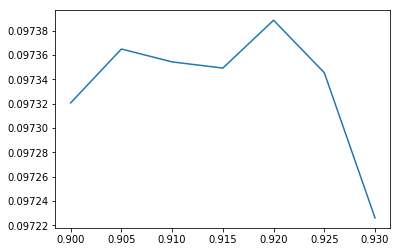

In [17]:

ensemble = EnsembleRecommender()
print("FITTING WITH ALFA = " +  str(BEST_ALFA))
ensemble.fit(urm_csr, icm_csr, alfa = BEST_ALFA)
print("EVALUATING...")
result.append(evaluate_algorithm(test_set_csr, ensemble, test_set_playlists))


# TESTING SINGLE ITERATION